# 信用卡欺诈预测

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('../../dataSet/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0,0.5,'Frequency')

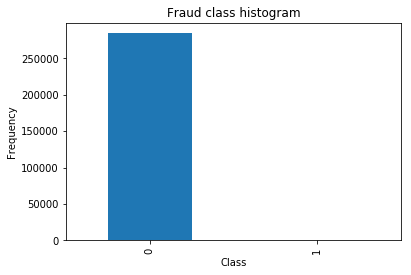

In [3]:
#查看每种标签的数据量
count_class = pd.value_counts(data['Class'],sort=True).sort_index()
count_class.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

特征中`Amount`特征的值与其他特征数据取值范围不同，会导致`Amount`数据权重过大，对于取值范围不同的特征，可以采用：**归一化**或**标准化**
* 归一化：将数据进行线性变换，把数据映射到[0,1]之间
* 标准化：常用的方法是z-score标准化。经过处理后的数据均值为0，标准差为1。该种归一化方式要求原始数据的分布可以近似为高斯分布，否则标准化的效果会变得很差。

二者区别
1. 在分类、聚类算法中，需要使用距离来度量相似性的时候、或者使用PCA技术进行降维的时候，第二种方法(Z-scorestandardization)表现更好。
2. 在不涉及距离了度量、协方差计算、数据不符合正太分布的时候，可以使用第一种方法或者其他归一化方法。比如图像处理中，将RGB图像转化为灰度图像后将其值限定在[0 255]的范围。

In [4]:
# 对Amount字段进行标准化
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))# 将Amount字段进行标准化处理
data = data.drop(['Time','Amount'],axis=1)# 删除废弃的列
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 使用下采样方式处理数据

从分布图中可以看出，两种标签数据分布极不均衡。需要对样本数据进行处理：**过采样**或**下采样**
* 过采样：制造数据量少的标签的样本数，使样本数与占比大的样本同样多
* 下采样：从样本多的数据中筛选，使得与样本少的数据集同样少

In [5]:
# 按列名拿数据，得到x与y
X=data.loc[:,data.columns!='Class']
y = data.loc[:,data.columns=='Class']

# 得到欺诈数据相关内容
number_records_fraud = len(data[data['Class']==1]) # 欺诈数据样本个数
fraud_indices = np.array(data[data['Class']==1].index) # 得到欺诈数据的index值

# 得到正常数据的相关内容
normal_indices = data[data['Class']==0].index # 得到正常数据的index值

# 从正常样本中进行随机选择。参数含义：从正常的数据的index中进行选择，选择条数为异常数据的条数，并且不替换原始数据
random_normal_indices = np.random.choice(normal_indices,number_records_fraud,replace=False) # 得到随机选择后的正常样本数据index
random_normal_indices = np.array(random_normal_indices) # 将结果转化为np.array格式

# 将随机选择后的正常数据index结果与异常数据index集合进行合并
under_sample_indices  = np.concatenate([fraud_indices,random_normal_indices])

# 通过index集合得到实际数据集
under_sample_data = data.iloc[under_sample_indices,:]

X_under_sample_data = under_sample_data.loc[:,under_sample_data.columns!='Class'] # 得到所有特征
y_under_sample_data = under_sample_data.loc[:,under_sample_data.columns=='Class'] # 得到所有标签

print('正样本占比：',len(under_sample_data[under_sample_data['Class']==0])/len(under_sample_data))
print('负样本占比：',len(under_sample_data[under_sample_data['Class']==1])/len(under_sample_data))
print('所有样本条数：',len(under_sample_data))

正样本占比： 0.5
负样本占比： 0.5
所有样本条数： 984


### 交叉验证
将测试集数据进行平分，平分后的数据分别作为训练集与验证集对模型进行评估，将每次得到的准确率取平均值，则可认为是模型的准确率

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# 对原始数据进行训练集与测试集的切分
X_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

print("训练集数量：",len(X_train))
print('测试集数量：',len(x_test))
print('总数据量：',len(X_train)+len(x_test))

# 对下采样数据进行训练集与测试集切分
X_train_undersample,x_test_undersample,y_train_undersample,y_test_undersample = train_test_split(X_under_sample_data,y_under_sample_data,test_size=0.3,random_state=0)
print("")
print("下采样数据训练集数量：",len(X_train_undersample))
print("下采样数据测试集数量：",len(x_test_undersample))
print("下采样总体数据量：",len(X_train_undersample)+len(x_test_undersample))

训练集数量： 199364
测试集数量： 85443
总数据量： 284807

下采样数据训练集数量： 688
下采样数据测试集数量： 296
下采样总体数据量： 984


### 使用逻辑回归建模

模型的评估标准：单纯的看模型准确度可能会有问题。模型的准确率=预测正确的人数/总人数。
举例：当有1000个病人，其中990个不患癌症，10个患癌症。我们的模型预期是想要得到患有癌症的人。如果10个患癌中指检测到了8个人，说明模型准确率为80%。但从另一个角度讲，模型检测结果为所有人都不患癌症，则检测正确的概率为990/1000=99%，反而比上一个要高，但其实后者的模型没有任何意义。

召回率含义：模型的目的为找到信用卡欺诈的数据。对于信用卡欺诈的数据，**召回率=信用卡欺诈预测正确的个数/信用卡欺诈的真实个数**

In [8]:
from sklearn.linear_model import LogisticRegression # 线性回归模块
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report

/Users/zhangdi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) # 交叉验证，将数据集切分成5部分
    
    # 设置惩罚项力度
    c_param_range = [0.01,0.1,1,10,100]
    
    results_table = pd.DataFrame(index=range(len(c_param_range),2),columns=['C_parameter','Mean recall score'])# 创建返回结果集
    results_table['C_parameter'] = c_param_range 

    j=0
    for c_param in c_param_range: # 循环正则化惩罚项力度
        print('-------------------')
        print('交叉验证力度：',c_param)
        print('-------------------')
        print('')
        
        recall_accs = []
        for iteration,indices in enumerate(fold,start=1): # 此处iteration为次数，indices结构为(array([1, 2, 3, 4]), array([0]))，前半部分表示训练集index，后半部分表示测试集index
            lr = LogisticRegression(C = c_param,penalty='l1') # 创建逻辑回归模型。使用l1正则化
            
            # x_train_data.iloc[indices[0],:] 得到第一列的所有元素，
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel()) # 使用交叉验证数据训练模型
            
            # x_train_data.iloc[indices[1],:]得到第二列的所有元素
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values) # 对每一个模型进行预测准确度验证
            
            # 计算召回率。
            # 召回率=提取出的正确信息条数 /样本中的信息条数。通俗地说，就是所有准确的条目有多少被检索出来了
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample) # 计算每一次的召回率
            recall_accs.append(recall_acc) # 将召回率添加到列表中
            print("交叉验证次数： ", iteration," : 召回率 = ", recall_acc)
        
        # 打印内容
        results_table.loc[j,"Mean recall score"] = np.mean(recall_accs) # 将平均匹配率
        j+=1
        print('')
        print("平均匹配率：", np.mean(recall_accs))
        print('')
    
    results_table['Mean recall score']=results_table['Mean recall score'].astype('float64')
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter'] #得到Mean recall score最大值时的C_parameter值]
    
    print('**********************************************************************')
    print("最优的正则化惩罚项力度C parameter = ",best_c)
    print('**********************************************************************')
    
    return best_c

In [10]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------
交叉验证力度： 0.01
-------------------

交叉验证次数：  1  : 召回率 =  0.9452054794520548
交叉验证次数：  2  : 召回率 =  0.9178082191780822
交叉验证次数：  3  : 召回率 =  1.0
交叉验证次数：  4  : 召回率 =  0.9594594594594594
交叉验证次数：  5  : 召回率 =  0.9696969696969697

平均匹配率： 0.9584340255573132

-------------------
交叉验证力度： 0.1
-------------------

交叉验证次数：  1  : 召回率 =  0.8493150684931506
交叉验证次数：  2  : 召回率 =  0.863013698630137
交叉验证次数：  3  : 召回率 =  0.9322033898305084
交叉验证次数：  4  : 召回率 =  0.9459459459459459
交叉验证次数：  5  : 召回率 =  0.9090909090909091

平均匹配率： 0.8999138023981302

-------------------
交叉验证力度： 1
-------------------

交叉验证次数：  1  : 召回率 =  0.863013698630137
交叉验证次数：  2  : 召回率 =  0.8904109589041096
交叉验证次数：  3  : 召回率 =  0.9830508474576272
交叉验证次数：  4  : 召回率 =  0.9459459459459459
交叉验证次数：  5  : 召回率 =  0.9242424242424242

平均匹配率： 0.9213327750360488

-------------------
交叉验证力度： 10
-------------------

交叉验证次数：  1  : 召回率 =  0.863013698630137
交叉验证次数：  2  : 召回率 =  0.8904109589041096
交叉验证次数：  3  : 召回率 =  0.9830508474576272
交叉验证

### 混淆矩阵。用于观察预测的正确率

In [11]:
# 画混淆矩阵。用于查看最终匹配成功与失败的个数
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=0)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment = 'center',color='white' if cm[i,j]>thresh else 'black')

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel('Predicted label')

采用下采样数据集的召回率结果为： 0.9319727891156463


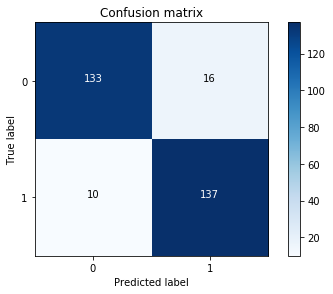

In [12]:
import itertools
lr = LogisticRegression(C=best_c,penalty='l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(x_test_undersample.values)

cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print('采用下采样数据集的召回率结果为：',cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_name=[0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_name,title='Confusion matrix')
plt.show()

全集数据的召回率结果为： 0.9183673469387755


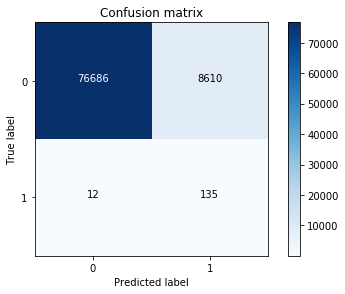

In [13]:
lr = LogisticRegression(C=best_c,penalty='l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(x_test.values)

cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print('全集数据的召回率结果为：',cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_name=[0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_name,title='Confusion matrix')

In [23]:
best_c = printing_Kfold_scores(X_train,y_train)

-------------------
交叉验证力度： 0.01
-------------------

交叉验证次数：  1  : 召回率 =  0.4925373134328358
交叉验证次数：  2  : 召回率 =  0.6027397260273972
交叉验证次数：  3  : 召回率 =  0.6833333333333333
交叉验证次数：  4  : 召回率 =  0.5692307692307692
交叉验证次数：  5  : 召回率 =  0.45

平均匹配率： 0.5595682284048672

-------------------
交叉验证力度： 0.1
-------------------

交叉验证次数：  1  : 召回率 =  0.5671641791044776
交叉验证次数：  2  : 召回率 =  0.6164383561643836
交叉验证次数：  3  : 召回率 =  0.6833333333333333
交叉验证次数：  4  : 召回率 =  0.5846153846153846
交叉验证次数：  5  : 召回率 =  0.525

平均匹配率： 0.5953102506435158

-------------------
交叉验证力度： 1
-------------------

交叉验证次数：  1  : 召回率 =  0.5522388059701493
交叉验证次数：  2  : 召回率 =  0.6164383561643836
交叉验证次数：  3  : 召回率 =  0.7166666666666667
交叉验证次数：  4  : 召回率 =  0.6153846153846154
交叉验证次数：  5  : 召回率 =  0.5625

平均匹配率： 0.612645688837163

-------------------
交叉验证力度： 10
-------------------

交叉验证次数：  1  : 召回率 =  0.5522388059701493
交叉验证次数：  2  : 召回率 =  0.6164383561643836
交叉验证次数：  3  : 召回率 =  0.7333333333333333
交叉验证次数：  4  : 召回率 =  0.615

### 根据混淆矩阵来观察最合适的预设值。
系统默认预设值为0.5，我们可以修改此预测值的阀值来达到更好的预测目的

Recall metric in the testing dataset： 1.0
Recall metric in the testing dataset： 1.0
Recall metric in the testing dataset： 1.0
Recall metric in the testing dataset： 0.9863945578231292
Recall metric in the testing dataset： 0.9319727891156463
Recall metric in the testing dataset： 0.8775510204081632
Recall metric in the testing dataset： 0.8367346938775511
Recall metric in the testing dataset： 0.7619047619047619
Recall metric in the testing dataset： 0.5850340136054422


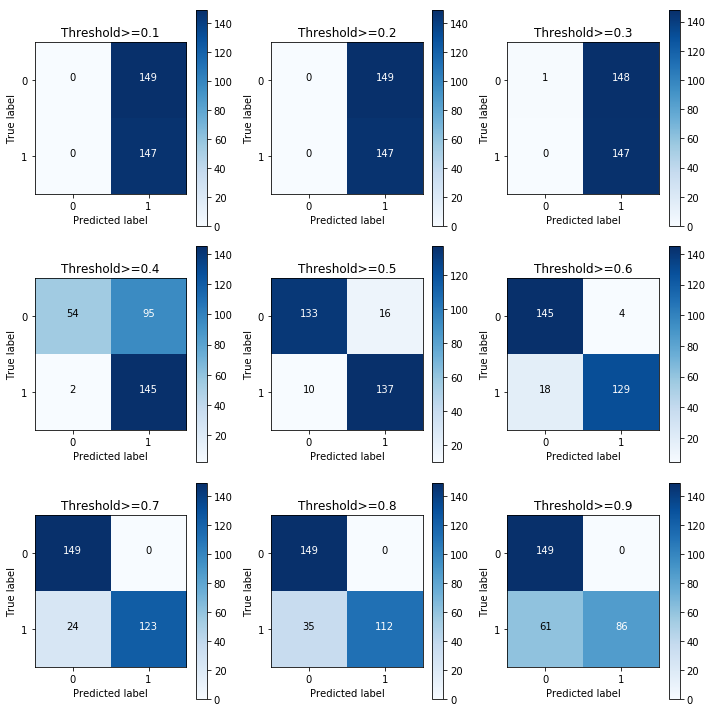

In [15]:
lr = LogisticRegression(C=0.01,penalty='l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(x_test_undersample.values) #predict_proba 直接预测出概率值

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # 将预置设置为0.1-0.9，观察每一种预置的结果
plt.figure(figsize=(10,10))
j=1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1]>i
    
    plt.subplot(3,3,j)
    j+=1
    
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    print('Recall metric in the testing dataset：',cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_name,title='Threshold>=%s'%i)
    

### 过采样
SMOTE算法：
1. 对于少数类中每一个样本x，以欧式距离为标准计算它到少数类样本集中所有样本的距离，得到其k近邻
2. 根据样本不平衡比例设置一个采样比例以确定采样倍率N，对每一个少数类样本x，从其k近邻中随机选择若干个样本，假设选择的近邻为xn。
3. 对于每一个随机选出的近邻xn，分别与原样本按照如下的公式构建新的样本
$$x_{new}=x+rand(0,1)\times(\tilde{x}-x) $$

In [16]:
from imblearn.over_sampling import SMOTE # 此库在anaconda中需要安装。anaconda包库中不包含此内容，需要手动在anaconda命令行中进行安装
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [17]:
credit_cards = pd.read_csv('../../dataSet/creditcard.csv')

columns = credit_cards.columns

features_columns = columns.delete(len(columns)-1)

features = credit_cards[features_columns]
labels = credit_cards['Class']

In [18]:
features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=0.2,random_state=0)

In [19]:
oversampler = SMOTE(random_state=0)
os_features,os_labels = oversampler.fit_sample(features_train,labels_train) #对训练集进行学习。会自动将标签是0与1的个数进行平衡。

In [20]:
print(len(os_labels[os_labels==1]))# 得到新的标签为1的数据集
print(len(os_labels[os_labels==0]))

227454
227454


In [21]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = printing_Kfold_scores(os_features,os_labels)

-------------------
交叉验证力度： 0.01
-------------------

交叉验证次数：  1  : 召回率 =  0.8903225806451613
交叉验证次数：  2  : 召回率 =  0.8947368421052632
交叉验证次数：  3  : 召回率 =  0.9682859355980967
交叉验证次数：  4  : 召回率 =  0.9578373506556314
交叉验证次数：  5  : 召回率 =  0.9584198898671151

平均匹配率： 0.9339205197742535

-------------------
交叉验证力度： 0.1
-------------------

交叉验证次数：  1  : 召回率 =  0.8903225806451613
交叉验证次数：  2  : 召回率 =  0.8947368421052632
交叉验证次数：  3  : 召回率 =  0.9702777470399468
交叉验证次数：  4  : 召回率 =  0.9594530726195579
交叉验证次数：  5  : 召回率 =  0.9603653510073532

平均匹配率： 0.9350311186834563

-------------------
交叉验证力度： 1
-------------------

交叉验证次数：  1  : 召回率 =  0.8903225806451613
交叉验证次数：  2  : 召回率 =  0.8947368421052632
交叉验证次数：  3  : 召回率 =  0.9705433218988603
交叉验证次数：  4  : 召回率 =  0.9587606203493036
交叉验证次数：  5  : 召回率 =  0.9604752640661237

平均匹配率： 0.9349677258129423

-------------------
交叉验证力度： 10
-------------------

交叉验证次数：  1  : 召回率 =  0.8903225806451613
交叉验证次数：  2  : 召回率 =  0.8947368421052632
交叉验证次数：  3  : 召回率 =  0.970

Recall metric in the testing dataset ： 0.900990099009901


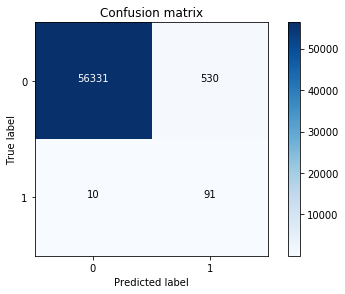

In [22]:
lr = LogisticRegression(C=best_c,penalty='l1')
lr.fit(os_features,os_labels.values.ravel())
y_pred = lr.predict(features_test.values)

cnf_matrix = confusion_matrix(labels_test,y_pred)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset ：',cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_name=[0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')
plt.show()